In [12]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import Model
from keras.models import load_model, Sequential, save_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.metrics import AUC, Precision, Recall
from keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils import class_weight

import os

# from utils import *

# %reload_ext autoreload
# %autoreload 2


## Set up the file directory and image paths

In [6]:
# generating augmentations through ImageDataGenerator
image_generator = ImageDataGenerator(rescale=1./255)


# assigning paths
train_folder = '../data/tuberculosis-detection-model/augmented_sorted/train'
val_folder = '../data/tuberculosis-detection-model/original_sorted/val'
test_folder = '../data/tuberculosis-detection-model/original_sorted/test'

TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
IMAGE_SIZE = 224

train_generator = image_generator.flow_from_directory(train_folder, 
                                                      batch_size=BATCH_SIZE, 
                                                      shuffle=True, 
                                                      class_mode='binary',
                                                      target_size=TARGET_SIZE,
                                                      seed=42)

val_generator = image_generator.flow_from_directory(val_folder,
                                                    target_size=TARGET_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode = 'binary',
                                                    seed=42)

test_generator = image_generator.flow_from_directory(test_folder,
                                                     target_size=TARGET_SIZE,
                                                     batch_size = 1,
                                                     class_mode = 'binary',
                                                     shuffle=False, 
                                                     seed=42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 9822 images belonging to 2 classes.
Found 1033 images belonging to 2 classes.
Found 1036 images belonging to 2 classes.


In [7]:
# calculate class weights
total_tb = len(os.listdir(os.path.join(train_folder, 'TB')))
total_healthy = len(os.listdir(os.path.join(train_folder, 'Non-TB')))

weight_for_0 = total_tb / (total_healthy + total_tb)
weight_for_1 = total_healthy / (total_healthy + total_tb)

class_weights = {0: weight_for_0, 1: weight_for_1}
class_weights

{0: 0.38098147016900835, 1: 0.6190185298309917}

In [10]:
# create model
def DenseNet121_Model():
    baseModel = DenseNet121(weights='imagenet', include_top=False, input_tensor= tf.keras.layers.Input(shape=(224, 224, 3)))
    output = baseModel.output
    output = AveragePooling2D(pool_size=(2, 2))(output)
    output = Flatten(name="flatten")(output)
    output = Dense(512, activation="relu")(output)
    output = Dropout(0.25)(output)
    output = Dense(1, activation="sigmoid")(output)
    model = Model(inputs=baseModel.input, outputs=output)
    # loop over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    return model

model = DenseNet121_Model()

INIT_LR = 0.001
EPOCHS = 20
BATCHSIZE = 32 

# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS),
              metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [14]:
# define callbacks
# earlyStopping = EarlyStopping(monitor = 'val_loss', 
#                               verbose = 1, 
#                               mode = 'min', 
#                               patience = 4)

lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)

modelPath = "logs/log_densenet"
if not os.path.exists(modelPath):
    os.makedirs(modelPath)
    print('Model Directory Created')
else:
    print('Model Directory Already Exists')

mcp_save = ModelCheckpoint("logs/log_densenet/model.{epoch:02d}-{val_loss:.2f}.hdf5", 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('logs/log_densenet/log.csv')

save_model(model, "logs/log_densenet/DenseNet121-model.h5", 
           overwrite=True, 
           include_optimizer=True, 
           save_format=None,
           signatures=None, 
           options=None)

Model Directory Created


In [15]:
# train model
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    class_weight = class_weights,
                    callbacks = [mcp_save, lr_reduction, csv_logger])

Epoch 1/20


2023-08-29 04:09:04.916742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.8424 - auc: 0.8825 - auc_1: 0.7982 - precision: 0.7662 - recall: 0.8441

2023-08-29 04:11:32.291425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to logs/log_densenet/model.01-0.68.hdf5
306/306 [==============================] - 184s 563ms/step - loss: 0.9532 - accuracy: 0.8424 - auc: 0.8825 - auc_1: 0.7982 - precision: 0.7662 - recall: 0.8441 - val_loss: 0.6828 - val_accuracy: 0.8496 - val_auc: 0.9571 - val_auc_1: 0.8096 - val_precision: 0.6043 - val_recall: 0.9654 - lr: 0.0010
Epoch 2/20
306/306 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9322 - auc: 0.9751 - auc_1: 0.9601 - precision: 0.8962 - recall: 0.9294
Epoch 2: saving model to logs/log_densenet/model.02-0.22.hdf5
306/306 [==============================] - 167s 544ms/step - loss: 0.1156 - accuracy: 0.9322 - auc: 0.9751 - auc_1: 0.9601 - precision: 0.8962 - recall: 0.9294 - val_loss: 0.2211 - val_accuracy: 0.9492 - val_auc: 0.9791 - val_auc_1: 0.9131 - val_precision: 0.8403 - val_recall: 0.9567 - lr: 0.0010
Epoch 3/20
306/306 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9433 - auc: 0.9826 - auc_

In [16]:
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    class_weight = class_weights,
                    callbacks = [mcp_save, lr_reduction, csv_logger])

Epoch 1/20
306/306 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9938 - auc: 0.9997 - auc_1: 0.9996 - precision: 0.9901 - recall: 0.9936
Epoch 1: saving model to logs/log_densenet/model.01-0.40.hdf5
306/306 [==============================] - 247s 803ms/step - loss: 0.0087 - accuracy: 0.9938 - auc: 0.9997 - auc_1: 0.9996 - precision: 0.9901 - recall: 0.9936 - val_loss: 0.3955 - val_accuracy: 0.9375 - val_auc: 0.9776 - val_auc_1: 0.8799 - val_precision: 0.7869 - val_recall: 0.9913 - lr: 1.5625e-05
Epoch 2/20
306/306 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9952 - auc: 0.9997 - auc_1: 0.9996 - precision: 0.9928 - recall: 0.9946
Epoch 2: saving model to logs/log_densenet/model.02-0.48.hdf5
306/306 [==============================] - 144s 471ms/step - loss: 0.0082 - accuracy: 0.9952 - auc: 0.9997 - auc_1: 0.9996 - precision: 0.9928 - recall: 0.9946 - val_loss: 0.4772 - val_accuracy: 0.9238 - val_auc: 0.9754 - val_auc_1: 0.8686 - val_pr

In [3]:
best_model = tf.keras.models.load_model('modeling/log_densenet/model.15-0.08.hdf5')

2023-08-21 10:06:03.384914: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-21 10:06:03.385035: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-21 10:06:03.385087: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-21 10:06:03.385425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-21 10:06:03.385899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
best_model.save_weights('modeling/log_densenet/densenet_weights.h5')

In [24]:
history

In [29]:
list(history.history.keys())[0]

['loss',
 'accuracy',
 'auc_4',
 'auc_5',
 'precision_2',
 'recall_2',
 'val_loss',
 'val_accuracy',
 'val_auc_4',
 'val_auc_5',
 'val_precision_2',
 'val_recall_2',
 'lr']

/var/folders/_1/5_00v86n0lvgk2xlkx9tzzcc0000gn/T/ipykernel_14476/3564992610.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


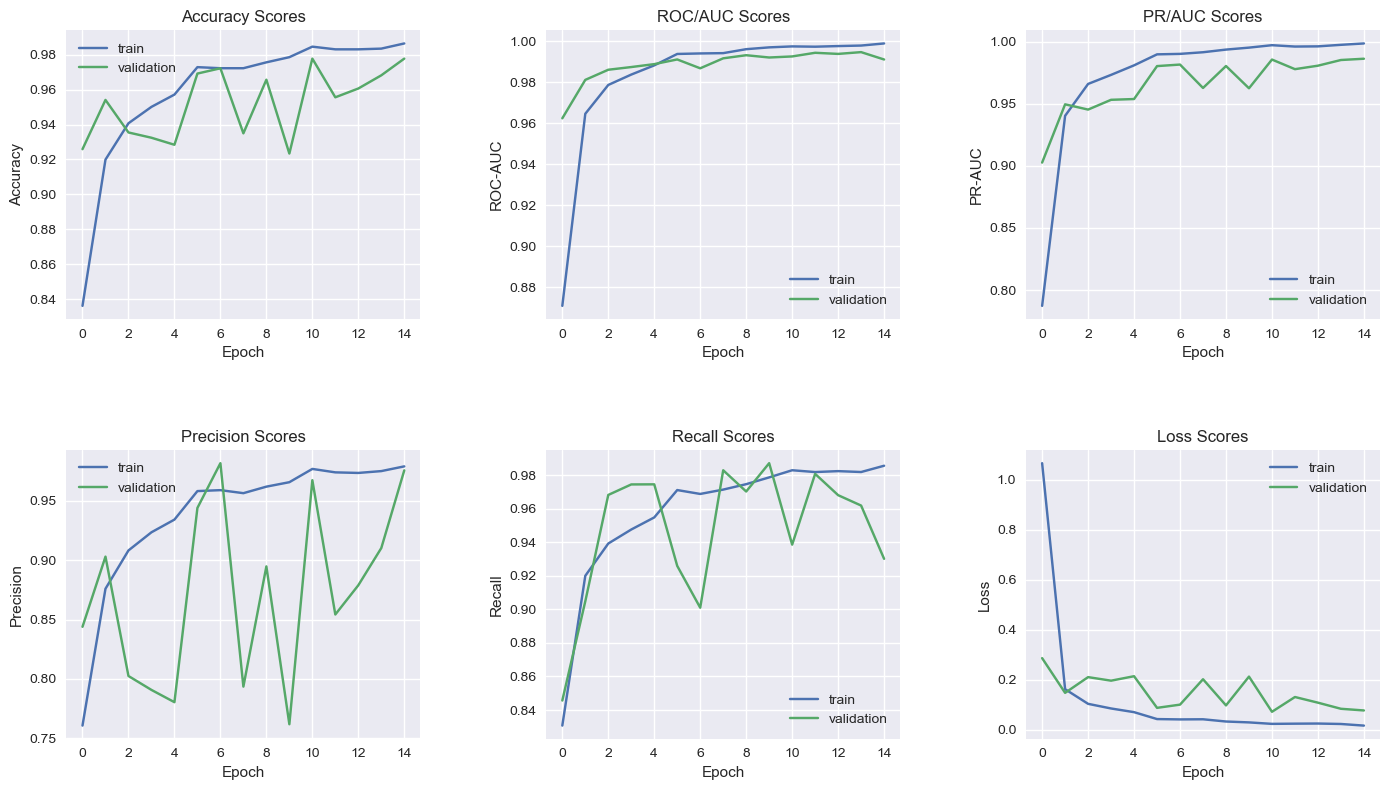

In [31]:
# evaluate model by displaying metrics with visualization
plt.style.use('seaborn')
plot_metrics(history, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

# Testing 

In [32]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))

/var/folders/_1/5_00v86n0lvgk2xlkx9tzzcc0000gn/T/ipykernel_14476/2042234192.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator, verbose = 1)


1036/1036 [==============================] - 62s 56ms/step - loss: 0.2835 - accuracy: 0.9488 - auc_4: 0.9780 - auc_5: 0.8736 - precision_2: 0.8396 - recall_2: 0.9574
Loss: 0.2835119068622589
Accuracy: 0.9488416910171509
Precision: 0.9780247807502747
Recall: 0.8736466765403748
ROC-AUC: 0.8395522236824036
PR-AUC: 0.957446813583374
